In [1]:
import sys
sys.path.append('..')

import metrics
from segmentation.tiramisu import tiramisu
from utils import transforms

import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

from collections import OrderedDict
import glob
from itertools import product
from os.path import join, basename, exists
from os import makedirs

In [2]:
def load_checkpoint(ckpt_path):
    checkpoint = torch.load(ckpt_path)
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['best_loss']
    best_metrics = checkpoint['best_metrics']
    train_metric_history = checkpoint['train_metrics_history']
    val_metric_history = checkpoint['val_metrics_history']
    model_state_dict = checkpoint['model_state_dict']
    optimizer_state_dict = checkpoint['optimizer_state_dict']
    hparams = checkpoint['hparams']

    return start_epoch, best_loss, best_metrics, \
           train_metric_history, val_metric_history, \
           model_state_dict, optimizer_state_dict, hparams

In [3]:
ckpt_path = '../log/runs/Sat_Dec_15_03-05-22_2018/checkpoint.best.pth.tar'
start_epoch, best_loss, best_metrics, \
train_metric_history, val_metric_history, \
model_state_dict, optimizer_state_dict, hparams = load_checkpoint(ckpt_path)

model = tiramisu.__dict__[hparams['model_params']['model']](2)

new_state_dict = OrderedDict()
for k, v in model_state_dict.items():
    name = k[7:]  # remove `module.`
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

if torch.cuda.is_available():
    model = torch.nn.DataParallel(model).cuda()
model.eval()

DataParallel(
  (module): FCDenseNet(
    (firstconv): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (denseBlocksDown): ModuleList(
      (0): DenseBlock(
        (layers): ModuleList(
          (0): DenseLayer(
            (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace)
            (conv): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (drop): Dropout2d(p=0.2)
          )
          (1): DenseLayer(
            (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace)
            (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (drop): Dropout2d(p=0.2)
          )
          (2): DenseLayer(
            (norm): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace)
            (conv): Conv2d(80, 16, kern

In [4]:
H_SIZE, W_SIZE = (224, 224)

In [5]:
transform = transforms.Compose([
    transforms.RandomCrop(H_SIZE, W_SIZE),
    transforms.ToTensor(normalize={
        "mean": [0.322, 0.339, 0.301],
        "std": [0.133, 0.133, 0.114]
    })])

In [6]:
pd.read_csv('../../data/segmentation/valid.csv').head()

,img_path,mask_path
0,YTS6DUZYSW5KADN1_17_14.png,YTS6DUZYSW5KADN1_17_14_mask.png
1,8B7JP60TYSMLOTJO_20_12.png,8B7JP60TYSMLOTJO_20_12_mask.png
2,E60M2WMELMJVAPBB_33_20.png,E60M2WMELMJVAPBB_33_20_mask.png
3,FOCNEZJJ9UP6IPIC_32_4.png,FOCNEZJJ9UP6IPIC_32_4_mask.png
4,A14OK5A65AR5AOST_14_8.png,A14OK5A65AR5AOST_14_8_mask.png


In [7]:
img = cv2.imread('../../data/segmentation/train/YTS6DUZYSW5KADN1/YTS6DUZYSW5KADN1.png')[..., ::-1]
mask = cv2.imread('../../data/segmentation/train/YTS6DUZYSW5KADN1/YTS6DUZYSW5KADN1_mask.png')[..., 0]

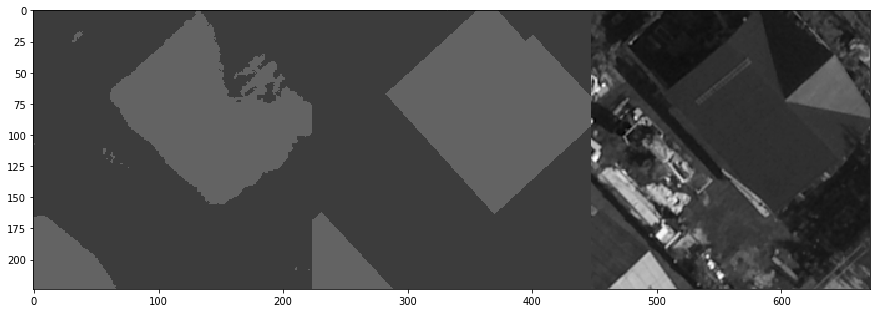

In [8]:
sample = transform(image=img, mask=mask)

pred = model.forward(sample['image'].unsqueeze(0))
pred = pred.argmax(1)
# pred = (pred.max(1)[0]) > 0.9
pred = pred.squeeze().data.cpu().numpy()

plt.figure(figsize=(15, 15))
imshow(np.hstack([pred, sample['mask'].squeeze().numpy(),
                  cv2.cvtColor(sample['image'].numpy().transpose(1, 2, 0), cv2.COLOR_RGB2GRAY)]),
      cmap='gray')

In [9]:
output = np.zeros_like(mask)

n_rows, n_cols = mask.shape[0] // H_SIZE, mask.shape[1] // W_SIZE    
for i, j in tqdm(product(range(n_rows), range(n_cols)), total=n_rows*n_cols):
    patch = img[i * H_SIZE:i * H_SIZE + H_SIZE, j * W_SIZE:j * W_SIZE + W_SIZE]
    patch_mask = mask[i * H_SIZE:i * H_SIZE + H_SIZE, j * W_SIZE:j * W_SIZE + W_SIZE]
    
    sample = t(image=patch)
    
    pred = model.forward(sample['image'].unsqueeze(0))
    pred = pred.argmax(1)
    pred = pred.squeeze().numpy()
    
    output[i * H_SIZE:i * H_SIZE + H_SIZE, j * W_SIZE:j * W_SIZE + W_SIZE] = pred

 48%|████▊     | 474/986 [27:20<30:25,  3.56s/it]

KeyboardInterrupt: 

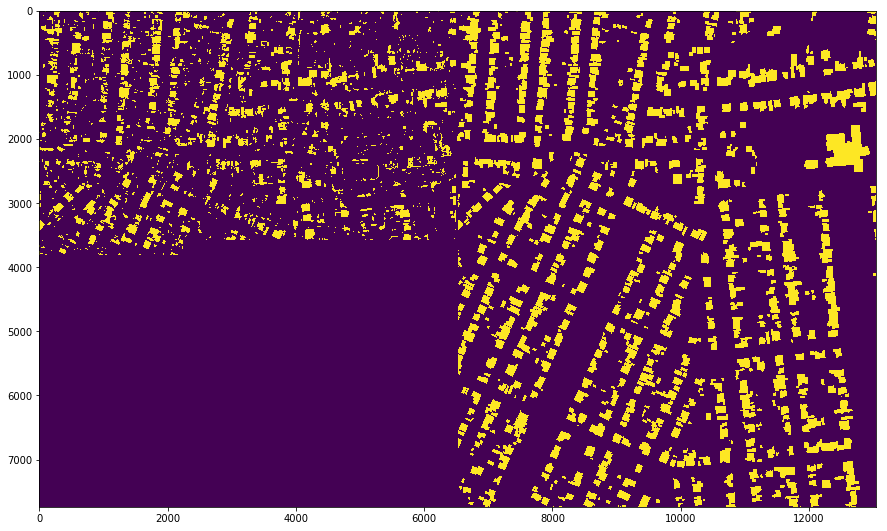

In [10]:
plt.figure(figsize=(15, 15))
imshow(np.hstack([output, mask // 255]))

In [9]:
class BatchIndex(Dataset):
    def __init__(self, img, h_size, w_size, step=0.3, transform=None):
        self.img = img
        self.h_size = h_size
        self.w_size = w_size
        self.step = step
        self.transform = transform
        
        self.n_rows = int(np.ceil(((img.shape[0]) / (h_size*(1 - step)))))
        self.n_cols = int(np.ceil(((img.shape[1]) / (w_size*(1 - step)))))
        self.total = self.n_rows * self.n_cols
        self.index = 0
        
        self.xs = []
        self.ys = []
    
    def __getitem__(self, index):
        if self.index >= self.total:
            raise Exception('Poshel v popu')
        
        row_idx = self.index // self.n_cols
        col_idx = self.index % self.n_cols
        
        pos_x = int(row_idx * (1. - self.step) * self.h_size)
        pos_y = int(col_idx * (1. - self.step) * self.w_size)
        patch = self.img[pos_x:pos_x + self.h_size, pos_y:pos_y + self.w_size]
        
        self.xs.append(pos_x)
        self.ys.append(pos_y)
        
        self.index += 1
        
        if self.transform is not None:
            patch = self.transform(image=patch)['image']
        
        return patch
    
    def get_pos_by_index(self, index):
        return self.xs[index], self.ys[index]
    
    def __len__(self):
        return self.total

In [10]:
def predict_for_img(img):
    t = transforms.Compose([
        transforms.Resize(224, 224),
        transforms.ToTensor(normalize={
            "mean": [0.322, 0.339, 0.301],
            "std": [0.133, 0.133, 0.114]
        })])

    indexer = BatchIndex(img, H_SIZE, W_SIZE, step=0.3, transform=t)
    loader = DataLoader(indexer, batch_size=20, shuffle=False,
                        num_workers=0, pin_memory=torch.cuda.is_available())
    preds = []

    for i, batch in tqdm(enumerate(loader), total=len(loader)):
        if torch.cuda.is_available():
            input_var = torch.autograd.Variable(batch.cuda(async=True), requires_grad=False)

        with torch.set_grad_enabled(False):
            pred = model.forward(input_var).data
            pred = pred.argmax(1)
            pred = pred.squeeze().cpu().numpy()

        preds.extend(pred[np.newaxis, ...])

    preds = np.vstack(preds)
    
    return indexer, preds

In [11]:
def build_map(indexer, preds):
    output = np.zeros((indexer.n_rows * H_SIZE, indexer.n_cols * W_SIZE),
                      dtype=mask.dtype)
    for idx in range(len(preds)):
        x, y = indexer.get_pos_by_index(idx)
        output[x:x + H_SIZE, y:y + W_SIZE] = preds[idx]

    output = output[:indexer.img.shape[0], :indexer.img.shape[1]]
    
    return output

In [17]:
indexer, preds = predict_for_img(img)
output = build_map(indexer, preds)

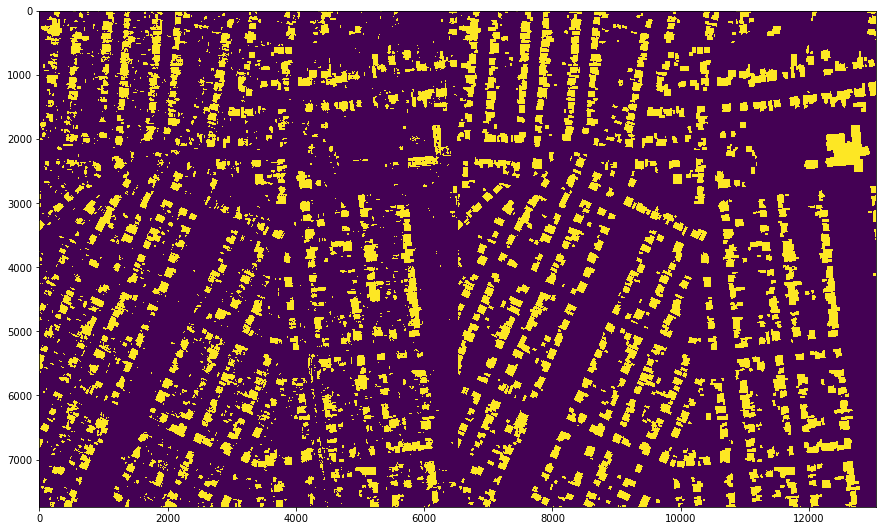

In [15]:
plt.figure(figsize=(15, 15))
imshow(np.hstack([output, mask // 255]))

In [19]:
n_comp, labels = cv2.connectedComponents(output)

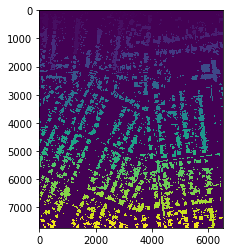

In [20]:
imshow(labels)

In [12]:
def instance_segment(output, area_t=100):
    n_comp, labels = cv2.connectedComponents(output)
    
    unique_labels, areas = np.unique(labels, return_counts=True)
    out = np.zeros_like(output)
    for i, (label, area) in tqdm(enumerate(zip(unique_labels[1:], areas[1:])),
                                 total=len(unique_labels) - 1):
        if area > area_t:
            label_mask = labels == label
            out[label_mask] = 1
            
    return out

In [22]:
out = instance_segment(output, area_t=1000)

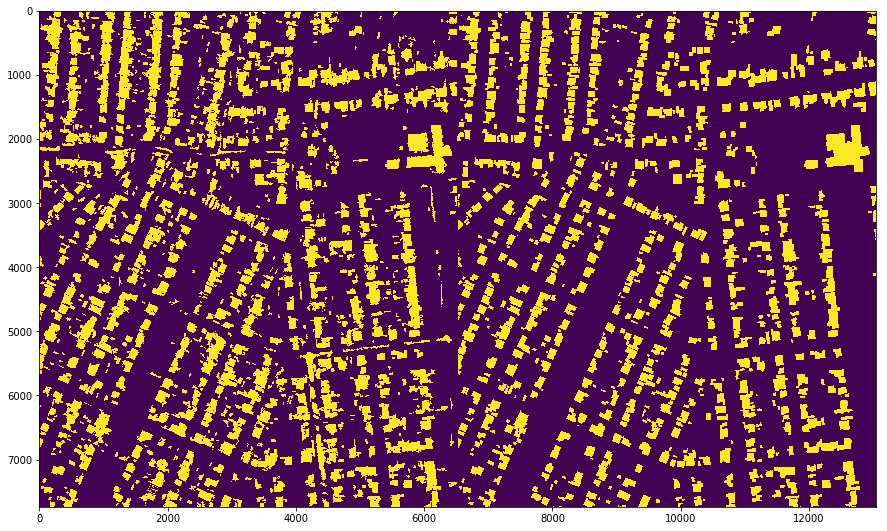

In [23]:
plt.figure(figsize=(15, 15))
imshow(np.hstack([out, mask // 255]))

In [13]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[:-1:2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [14]:
img_paths = glob.glob('../../data/segmentation/test/*/*.png')

outs = []
for img_path in img_paths:
    img = cv2.imread(img_path)[..., ::-1]
    indexer, preds = predict_for_img(img)
    output = build_map(indexer, preds)
    out = instance_segment(output, area_t=1000)
    
    outs.append(out)

In [15]:
instances = []
for out in outs:
    _, labels = cv2.connectedComponents(out)
    instances.append(labels)

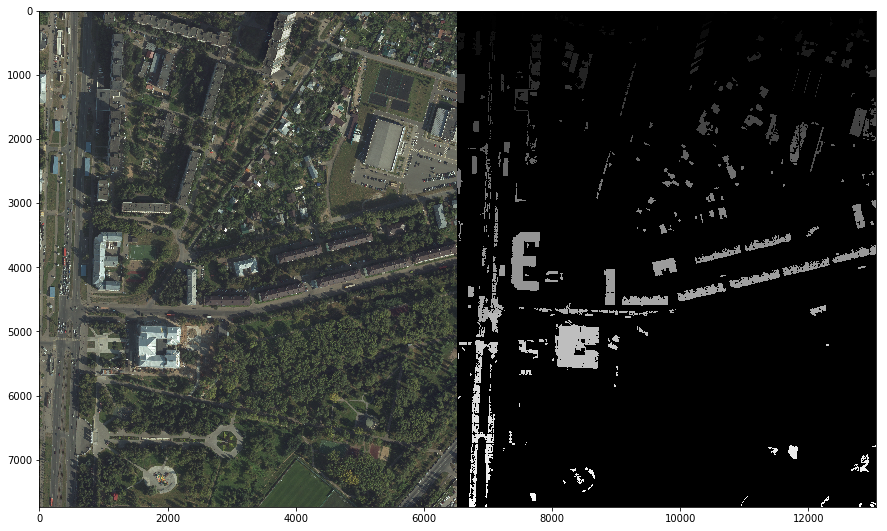

In [24]:
plt.figure(figsize=(15, 15))

idx = 0
imshow(np.hstack([
    cv2.imread(img_paths[idx])[..., ::-1] / 255.,
    np.dstack([instances[idx] / instances[idx].max()]*3)
]), cmap='coolwarm')

In [62]:
instances = []
codes = []
for out in outs:
    n_labels, labels = cv2.connectedComponents(out)
    instances.append(labels)
    
    codes_ = []
    for label in tqdm(range(1, n_labels)):
        m = labels == label
        code_ = rle_encode(m)
        codes_.append(code_)
    
    codes.append(codes_)

# for instance in instances:
    
#     code = rle_encode(instance)
#     codes.append(code)

In [63]:
pd_dict = {'img_path': [], 'mask': []}

for img_path, codes_ in zip(img_paths, codes):
    for code_ in codes_:
        pd_dict['img_path'].append(img_path)
        pd_dict['mask'].append(code_)

submit = pd.DataFrame(pd_dict)

In [65]:
submit.head()

,img_path,mask
0,../../data/segmentation/test/ZRYNEEUSVQ213QTY/...,5009 34 5050 114 11534 3 11538 37 11578 117 18...
1,../../data/segmentation/test/ZRYNEEUSVQ213QTY/...,16874 3 16884 6 16931 4 16938 2 23361 13 23393...
2,../../data/segmentation/test/ZRYNEEUSVQ213QTY/...,27135 12 33663 18 40194 16 46724 16 53254 16 5...
3,../../data/segmentation/test/ZRYNEEUSVQ213QTY/...,39698 9 39746 1 39748 1 39750 15 46228 9 46276...
4,../../data/segmentation/test/ZRYNEEUSVQ213QTY/...,62898 1 62900 1 62908 1 62910 1 62914 1 62916 ...


In [66]:
from os.path import basenamename

In [68]:
submit['img_path'] = submit['img_path'].apply(lambda path: basename(path))

In [69]:
submit.to_csv('../../data/segmentation/submit1.csv', index=False, header=None)

In [71]:
pd.read_csv('../../data/segmentation/submit1.csv', names=['img_path', 'mask']).head()

,img_path,mask
0,ZRYNEEUSVQ213QTY.png,5009 34 5050 114 11534 3 11538 37 11578 117 18...
1,ZRYNEEUSVQ213QTY.png,16874 3 16884 6 16931 4 16938 2 23361 13 23393...
2,ZRYNEEUSVQ213QTY.png,27135 12 33663 18 40194 16 46724 16 53254 16 5...
3,ZRYNEEUSVQ213QTY.png,39698 9 39746 1 39748 1 39750 15 46228 9 46276...
4,ZRYNEEUSVQ213QTY.png,62898 1 62900 1 62908 1 62910 1 62914 1 62916 ...
